# Objetivo

Analizar la base de datos **dataset_SCL.csv** que contiene información de los vuelos, en el dataset se encuentran las siguiente columnas con su descripción:

| Variable | Descripción |
| :- | :- |
| **Fecha-I**  | Fecha y hora programada del vuelo.
| **Vlo-I** | Número de vuelo programado.
| **Ori-I** | Código de ciudad de origen programado.
| **Des-I** | Código de ciudad de destino programado.
| **Emp-I** | Código aerolínea de vuelo programado.
| **Fecha-O** | Fecha y hora de operación del vuelo.
| **Vlo-O** | Número de vuelo de operación del vuelo.
| **Ori-O** | Código de ciudad de origen de operación.
| **Des-O** | Código de ciudad de destino de operación.
| **Emp-O** | Código aerolínea de vuelo operado.
| **DIA** | Día del mes de operación del vuelo.
| **MES** | Número de mes de operación del vuelo.
| **AÑO** | Año de operación del vuelo.
| **DIANOM** | Día de la semana de operación del vuelo.
| **TIPOVUELO** | Tipo de vuelo, I = Internacional, N = Nacional
| **OPERA** | Nombre de aerolínea que opera.
| **SIGLAORI** | Nombre de ciudad de origen.
| **SIGLADES** | Nombre ciudad destino.

In [1]:
# Librerías a utilizar
import os
import pandas as pd
import numpy as np
from datetime import datetime

# Para graficar
import seaborn as sns
import matplotlib.pyplot as plt

# Estadístico para la normalidad
from scipy.stats import shapiro

# Preprocesamiento de variables categóricas
from sklearn.preprocessing import OneHotEncoder

# Split data and grid search
from sklearn.model_selection import train_test_split, GridSearchCV

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

# save models
import pickle

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",None)

# Cambio de directorio
os.chdir("..")

from utilities import *
from config import *

In [4]:
path_save_synthetic_features = "data/synthetic_features.csv"
path_load_scl = "data/dataset_SCL.csv"

In [5]:
# Lectura de la data
df_scl = pd.read_csv(path_load_scl)

In [6]:
# Normalización de las columnas
df_scl.columns = [col.upper().replace("-","_") for col in df_scl.columns]
df_scl = df_scl.rename({"AÑO":"YEAR"},axis=1)

In [7]:
# Revisar cantidad de filas y columnas del dataset
df_scl.shape

(68206, 18)

In [8]:
df_scl.head()

,FECHA_I,VLO_I,ORI_I,DES_I,EMP_I,FECHA_O,VLO_O,ORI_O,DES_O,EMP_O,DIA,MES,YEAR,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [9]:
resume_col(df=df_scl,col="TIPOVUELO")

,TIPOVUELO,CONTEO,PORCENTAJE
0,N,36966,54.198%
1,I,31240,45.802%


In [10]:
resume_col(df=df_scl,col="DES_I")

,DES_I,CONTEO,PORCENTAJE
0,SCFA,5787,8.485%
1,SPJC,5270,7.727%
2,SCCF,5145,7.543%
3,SCTE,4357,6.388%
4,SCIE,3995,5.857%
...,...,...,...
59,SBFI,1,0.001%
60,SPSO,1,0.001%
61,SEQU,1,0.001%
62,SEQM,1,0.001%


In [11]:
resume_col(df=df_scl,col="DES_O")

,DES_O,CONTEO,PORCENTAJE
0,SCFA,5786,8.483%
1,SPJC,5270,7.727%
2,SCCF,5146,7.545%
3,SCTE,4357,6.388%
4,SCIE,3993,5.854%
...,...,...,...
58,SEQM,2,0.003%
59,KIAD,1,0.001%
60,SPSO,1,0.001%
61,EGYP,1,0.001%


In [12]:
resume_col(df=df_scl,col="EMP_I")

,EMP_I,CONTEO,PORCENTAJE
0,LAN,37611,55.143%
1,SKU,14298,20.963%
2,TAM,3049,4.47%
3,ARG,1949,2.858%
4,CMP,1850,2.712%
5,LAW,1574,2.308%
6,AVA,1152,1.689%
7,JAT,1095,1.605%
8,GLO,806,1.182%
9,AAL,757,1.11%


In [13]:
resume_col(df=df_scl,col="EMP_O")

,EMP_O,CONTEO,PORCENTAJE
0,LAN,20988,30.771%
1,LXP,14558,21.344%
2,SKU,14298,20.963%
3,TAM,3046,4.466%
4,ARG,1946,2.853%
5,CMP,1850,2.712%
6,JMR,1647,2.415%
7,LPE,1214,1.78%
8,JAT,1095,1.605%
9,AVA,885,1.298%


In [14]:
resume_col(df=df_scl,col="DIANOM")

,DIANOM,CONTEO,PORCENTAJE
0,Viernes,10292,15.09%
1,Jueves,10251,15.029%
2,Lunes,10131,14.854%
3,Domingo,9796,14.362%
4,Miercoles,9722,14.254%
5,Martes,9662,14.166%
6,Sabado,8352,12.245%


In [15]:
resume_col(df=df_scl,col="SIGLAORI")

,SIGLAORI,CONTEO,PORCENTAJE
0,Santiago,68206,100.0%


In [16]:
resume_col(df=df_scl,col="SIGLADES").head(10)

,SIGLADES,CONTEO,PORCENTAJE
0,Buenos Aires,6335,9.288%
1,Antofagasta,5786,8.483%
2,Lima,5270,7.727%
3,Calama,5146,7.545%
4,Puerto Montt,4357,6.388%
5,Concepcion,3993,5.854%
6,Iquique,3747,5.494%
7,Sao Paulo,3569,5.233%
8,Temuco,2589,3.796%
9,Arica,2436,3.572%


In [17]:
# El 80% de los viajes se manejan sobre el Grupo LATAM o Sky Airline
resume_col(df=df_scl,col="OPERA")

,OPERA,CONTEO,PORCENTAJE
0,Grupo LATAM,40892,59.954%
1,Sky Airline,14298,20.963%
2,Aerolineas Argentinas,1949,2.858%
3,Copa Air,1850,2.712%
4,Latin American Wings,1674,2.454%
5,Avianca,1152,1.689%
6,JetSmart SPA,1095,1.605%
7,Gol Trans,806,1.182%
8,American Airlines,757,1.11%
9,Air Canada,565,0.828%


### Observaciones

- Casi todos los días de la semana tienen un porcentaje similar.
- El grupo LATAM y Sky Airline abarcan casi la totalidad de vuelos, que es aproximadamente un 80% (OPERA).
- Existe incosistencia en el proveedor del vuelo, debido a que LATAM son aproximadamente 55% de los vuelos programados, pero al contrastar estos datos con el que realmente fue efectuado bajan a aproximadamente un 30% operados.
- Todos los viajes salen desde Santiago.
- El destino más solicitado en este periodo fue Buenos Aires.
- Un 54.2% de los vuelos son nacionales y un 45.8% de los vuelos son internacionales.
- En general existen diferencias entre los vuelos programados y los que realmente fueron operados.
### Supuesto
Se considera la fecha de operación la cual se realizó el vuelo, para esto es de interés saber cuantos vuelos tuvieron retraso, por lo que procedemos a calcular la diferencia entre la fecha de operación y la fecha programada del vuelo ($Fecha_O - Fecha_I$).

Además, se procede a calcular otras variables
- **temporada_alta**: 1 si la fecha del vuelo está en temporada alta y 0 si está en baja.
- **date_fmt**: Fecha formateada en formato %Y-%m-%d
- **atraso_15**: 1 si el vuelo tiene un atraso de al menos 15 minutos y 0 en otro caso

In [18]:
# Calculo de retraso de un vuelo (diferencia en minutos)
df_scl['dif_min'] = df_scl.apply(lambda row: diff_minutes(start=row['FECHA_I'], end=row['FECHA_O']), axis=1)
# Calculo de la temporada (alta o baja)
df_scl["temporada_alta"] = df_scl.FECHA_I.map(temporada_alta)
# Calculo de la fecha normalizada
df_scl["date_fmt"] = df_scl["FECHA_I"].map(date2date)
# Calculo de un atraso de 15 minutos
df_scl["atraso_15"] = df_scl["dif_min"].map(retraso)
# Calculo del periodo del día (mañana, tarde o noche)
df_scl["periodo_dia"] = df_scl["FECHA_I"].map(periodo_dia)

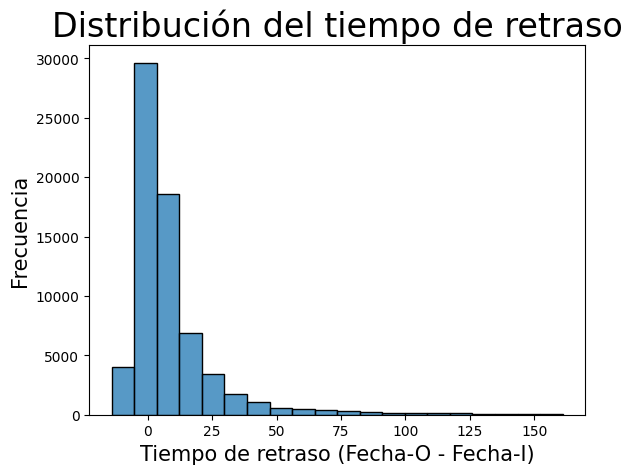

In [19]:
plt.title('Distribución del tiempo de retraso',fontsize=24)
sns.histplot(data=df_scl,x="dif_min",bins=20)
plt.ylabel("Frecuencia",fontsize=15)
plt.xlabel("Tiempo de retraso (Fecha-O - Fecha-I)",fontsize=15)
plt.show()

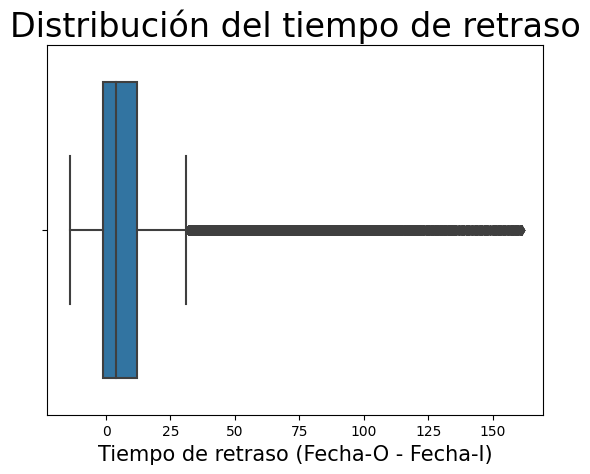

In [20]:
plt.title('Distribución del tiempo de retraso',fontsize=24)
sns.boxplot(df_scl.dif_min)
plt.xlabel("Tiempo de retraso (Fecha-O - Fecha-I)",fontsize=15)
plt.show()

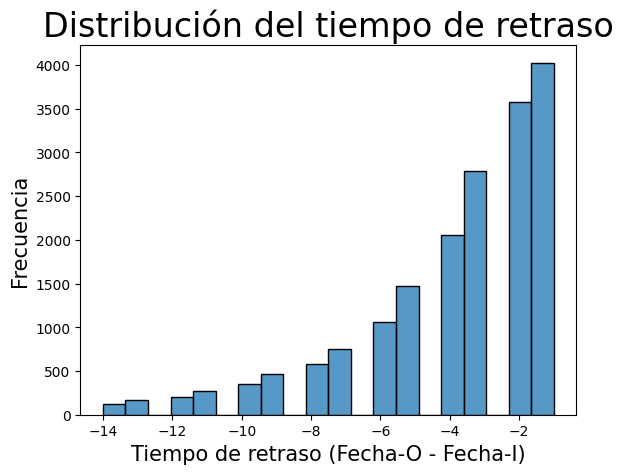

In [21]:
plt.title('Distribución del tiempo de retraso',fontsize=24)
resume = df_scl[df_scl["dif_min"]<0]
sns.histplot(data=resume,x="dif_min",bins=20)
plt.ylabel("Frecuencia",fontsize=15)
plt.xlabel("Tiempo de retraso (Fecha-O - Fecha-I)",fontsize=15)
plt.show()

## Observaciones:
- Existen datos negativos, esto quiere decir que el vuelo salió antes de la hora programada.
- Existe una asimetría hacia la derecha, lo cual existen vuelos con bastante retraso.
- Presencia de datos atípicos.
- No existe una gran diferencia de tiempo de aquellos vuelos que salieron antes de la hora programada.

### Calculo de datos atípicos

In [22]:
outliers, not_outliers = get_outliers(df_scl.dif_min)

In [23]:
print(f"Cantidad de datos outliers: {outliers.shape[0]}")
print(f"Cantidad de datos no outliers: {not_outliers.shape[0]}")

Cantidad de datos outliers: 5198
Cantidad de datos no outliers: 63008


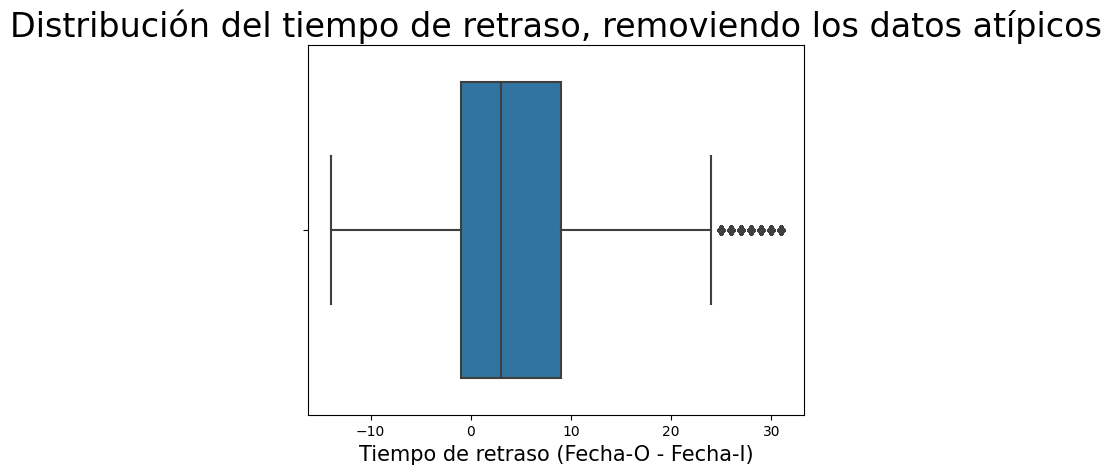

In [24]:
plt.title('Distribución del tiempo de retraso, removiendo los datos atípicos',fontsize=24)
ax = sns.boxplot(not_outliers)
plt.xlabel("Tiempo de retraso (Fecha-O - Fecha-I)",fontsize=15)
plt.show()

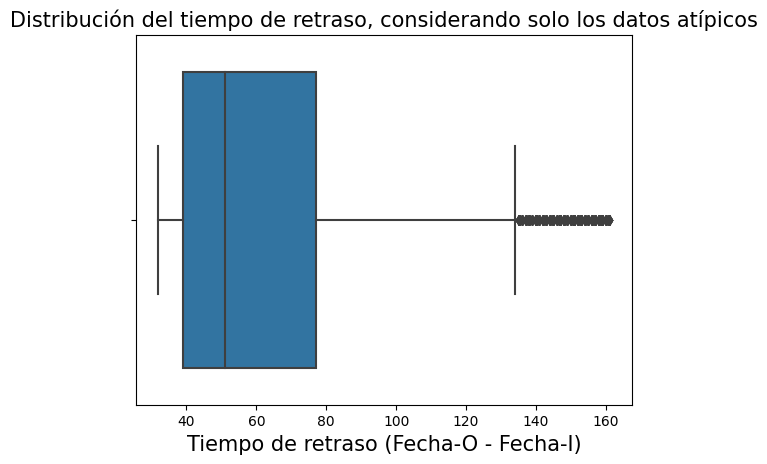

In [25]:
plt.title('Distribución del tiempo de retraso, considerando solo los datos atípicos',fontsize=15)
sns.boxplot(outliers)
plt.xlabel("Tiempo de retraso (Fecha-O - Fecha-I)",fontsize=15)
plt.show()

In [26]:
df_scl[df_scl["dif_min"]<0].shape

(17910, 23)

In [27]:
df_scl[df_scl["dif_min"]>=min(outliers)].shape[0]

5198

In [28]:
shapiro(df_scl["dif_min"])

ShapiroResult(statistic=0.6495827436447144, pvalue=0.0)

In [29]:
shapiro(not_outliers)

ShapiroResult(statistic=0.9482958912849426, pvalue=0.0)

## Observaciones
Se calcularon los datos atípicos y según su distribución todos aquellos vuelos con un retraso mayor a 31 minutos son considerados datos atípicos.
Se tienen 17910 vuelos que salieron antes de su hora programdo. Además, se tienen 5198 vuelos que son considerados outliers, esto quiere decir, que tuvieron un retraso de al menos 31 minutos.

Los datos no siguen una distribución normal, tanto para los datos con outliers, cómo para los datos sin los outliers. Por lo tanto, se debe considerar un modelo que no requiera el supuesto de normalidad de los datos.

In [30]:
resume_col(df=df_scl,col="atraso_15")

,atraso_15,CONTEO,PORCENTAJE
0,0,55592,81.506%
1,1,12614,18.494%


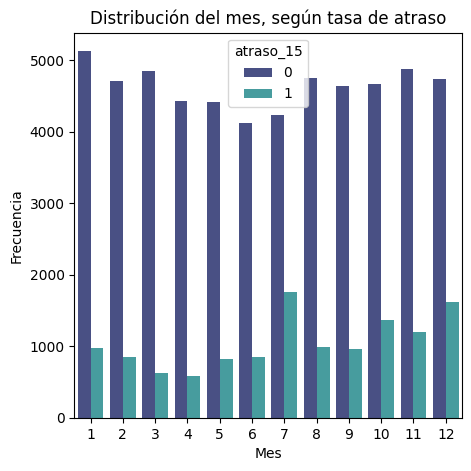

In [31]:
plt.figure(figsize=(5,5))
plt.title("Distribución del mes, según tasa de atraso")
ax = sns.countplot("MES",hue="atraso_15",data=df_scl,palette="mako")
plt.xlabel("Mes")
plt.ylabel("Frecuencia")
plt.show()

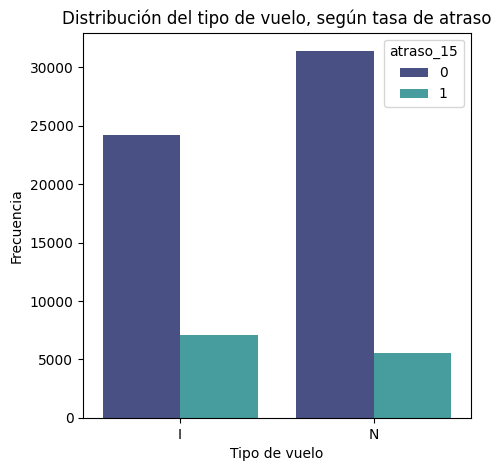

In [32]:
plt.figure(figsize=(5,5))
plt.title("Distribución del tipo de vuelo, según tasa de atraso")
ax = sns.countplot("TIPOVUELO",hue="atraso_15",data=df_scl,palette="mako")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de vuelo")
plt.show()

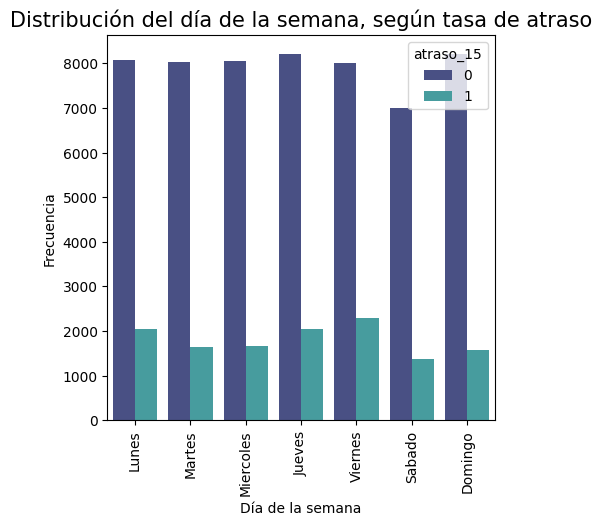

In [33]:
plt.figure(figsize=(5,5))
plt.title("Distribución del día de la semana, según tasa de atraso",fontsize=15)
ax = sns.countplot("DIANOM",hue="atraso_15",data=df_scl,palette="mako",order=["Lunes","Martes","Miercoles","Jueves","Viernes","Sabado","Domingo"])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.ylabel("Frecuencia")
plt.xlabel("Día de la semana")
plt.show()

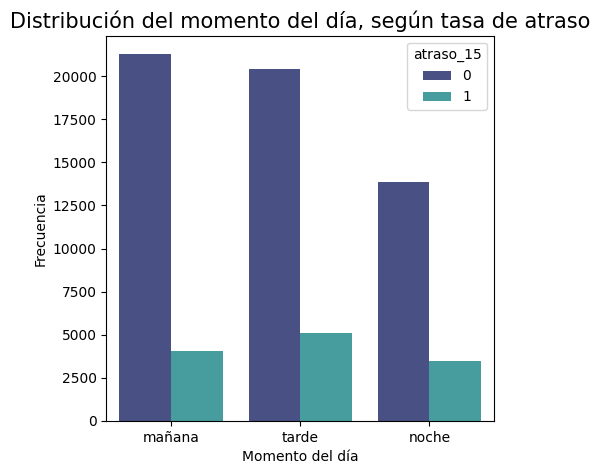

In [34]:
plt.figure(figsize=(5,5))
plt.title("Distribución del momento del día, según tasa de atraso",fontsize=15)
ax = sns.countplot("periodo_dia",hue="atraso_15",data=df_scl,palette="mako",order=["mañana","tarde","noche"])
plt.ylabel("Frecuencia")
plt.xlabel("Momento del día")
plt.show()

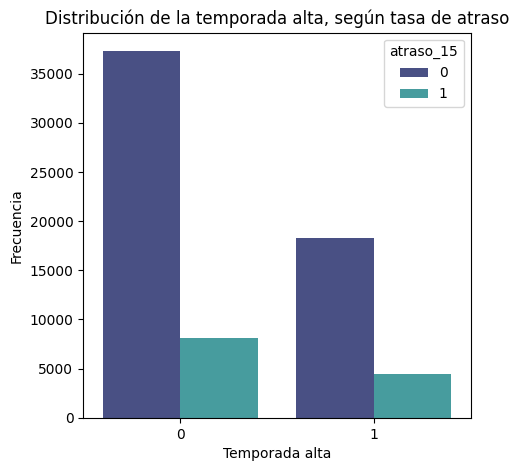

In [35]:
plt.figure(figsize=(5,5))
plt.title("Distribución de la temporada alta, según tasa de atraso")
ax = sns.countplot("temporada_alta",hue="atraso_15",data=df_scl,palette="mako")
plt.xlabel("Temporada alta")
plt.ylabel("Frecuencia")
plt.show()

### Observaciones
Se dispone de la variable objetivo cómo que ha tenido un retraso de 15 minutos o no (1 o 0). Los datos se encuentran desbalanceados de 81.5% para el 0 (que no tuvo retraso el vuelo) y 18.5% para el 1 (que obtuvo un retraso de al menos 15 minutos).

De las gráficas anteriores se concluye:
- Los meses de Julio y Diciembre son los meses que los vuelos más atrasos presentan. Sin embargo, la mayor tasa de atrasos se presentan en Julio.
- Los vuelos internacionales presentan una mayor tasa de atraso por sobre los nacionales (considerando que los viajes nacionales son más que los viajes internacionales).
- El día con mayor retraso se presenta el día viernes.
- El momento del día con mayor tasa de atraso se encuentra en la tarde (entre las 12:00 hrs y las 18:59 hrs).

In [36]:
df_scl.to_csv(path_save_synthetic_features,index=0)

In [37]:
df = pd.read_csv(path_save_synthetic_features)

# Preprocesamiento de datos
- La variable objetivo es **atraso_15**
- Las variables explicativas son: 
    - **DIANOM**
    - **TIPOVUELO**
    - **periodo_dia**
    - **temporada_alta**
    - **SIGLADES**
Las variables explicativas se aplicará un OneHotEncoder para llevar las variables a dummy.
# Modelado
Se construirá un modelo que prediga si un vuelo tendrá retraso de al menos 15 minutos. Para esto, construiremos modelos los siguientes modelos:
    - Con todas las observaciones (1 modelo)
    - Dividido por cada día de la semana (7 modelos)
    - Dividido por cada momento del día (3 modelos)

In [38]:
df.OPERA.value_counts(normalize=True).reset_index().iloc[1][0]

'Sky Airline'

In [39]:
df.loc[df.OPERA=='Grupo LATAM',"operador"] = "GRUPO LATAM"
df.loc[df.OPERA=='Sky Airline',"operador"] = "SKY AIRLINE"
df = df.fillna({"operador":"OTRO"})

In [56]:
features = ["DIANOM","TIPOVUELO","periodo_dia","temporada_alta","operador"]
target = "atraso_15"
metrics=None
path_metrics = "data/metrics_models/metrics.parquet"

rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


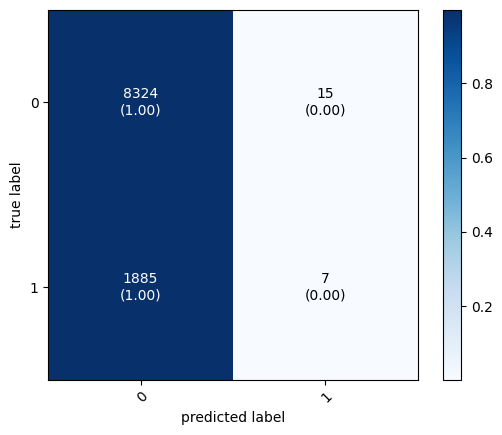

[INFO] model rf demoró 3.00597725 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


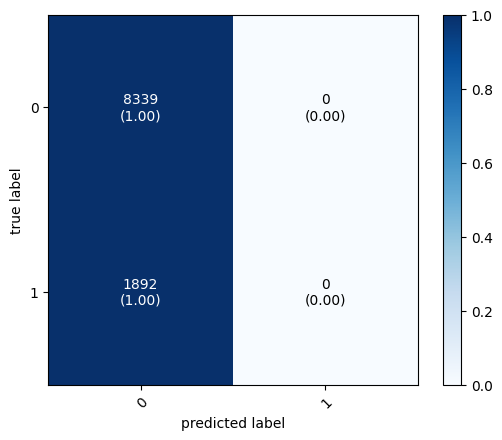

[INFO] model rl demoró 2.4278857 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


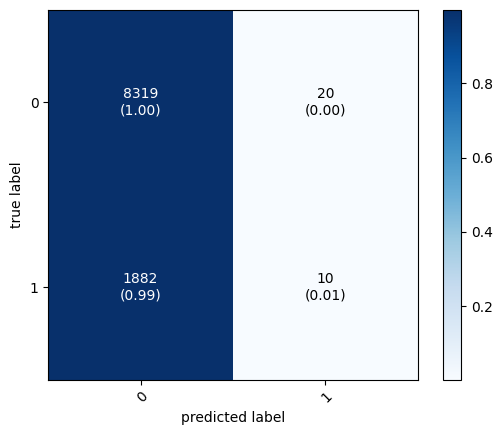

[INFO] model xgb demoró 1.6569620166666668 minutos en ejecutar
nb


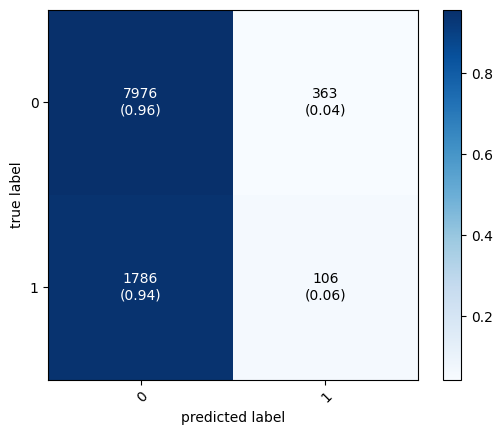

[INFO] model nb demoró 0.003795666666666667 minutos en ejecutar


In [67]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666,stratify=y)
ohe = OneHotEncoder()
ohe.fit(X_train)
X_train = ohe.transform(X_train).toarray()
X_test = ohe.transform(X_test).toarray()

models = ["rf","rl","xgb","nb"]
for model in models:
    start_iter = datetime.now()
    print(model)
    if model == "rf":
        grid_under = GridSearchCV(RandomForestClassifier(), param_rf, refit=True, verbose=1, scoring="f1_weighted")
    elif model == "rl":
        grid_under = GridSearchCV(LogisticRegression(), param_log, refit=True, verbose=1, scoring="f1_weighted")
    elif model == "nb":
        grid_under = GaussianNB()
    elif model == "xgb":
        grid_under = GridSearchCV(XGBClassifier(), param_xgb, refit=True, verbose=1, scoring="f1_weighted")
    path_model_save = f"models/atraso_completo/{model}.pickle"
    grid_under.fit(X_train, y_train)
    y_pred = grid_under.predict(X_test)
    metrics_res = get_report(y_test, y_pred)
    metrics_res["modelo"] = model
    metrics_res["tipo_modelo"] = "atraso_completo"
    if metrics is None:
        metrics_res.to_parquet(path_metrics)
        metrics = pd.read_parquet(path_metrics)
    else:
        metrics = pd.read_parquet(path_metrics)
        metrics_res = pd.concat([metrics,metrics_res])
        metrics_res.to_parquet(path_metrics)
    with open(path_model_save,"wb") as f:
        pickle.dump(grid_under,f)
    end_iter = datetime.now()
    print(f"[INFO] model {model} demoró {(end_iter-start_iter).total_seconds()/60} minutos en ejecutar")

rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


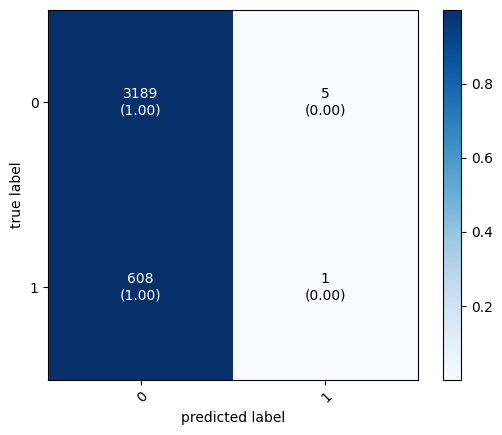

[INFO] model rf demoró 1.2286186000000001 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


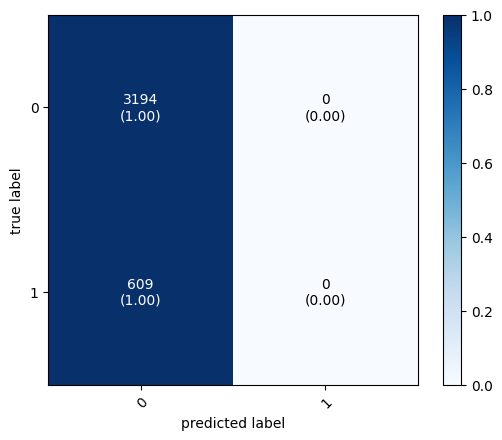

[INFO] model rl demoró 0.4867918 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


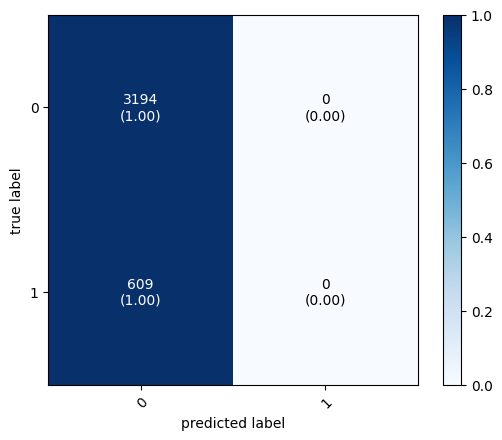

[INFO] model xgb demoró 0.6198040333333333 minutos en ejecutar
nb


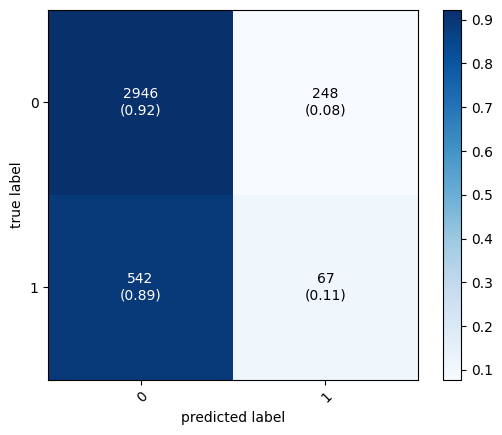

[INFO] model nb demoró 0.0035519333333333333 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


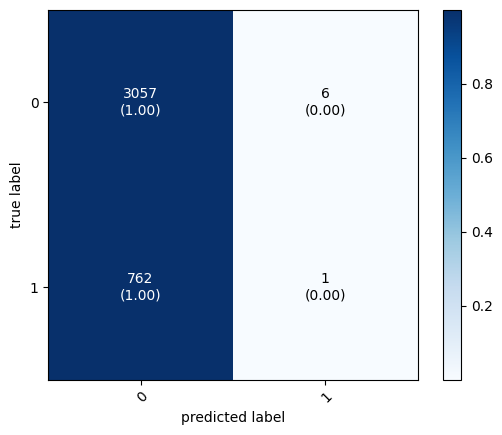

[INFO] model rf demoró 1.3184197166666667 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


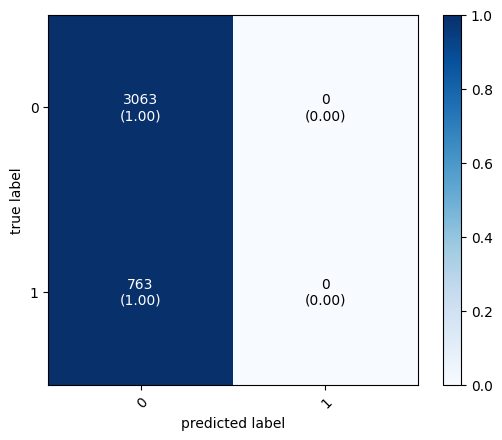

[INFO] model rl demoró 0.40281819999999996 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


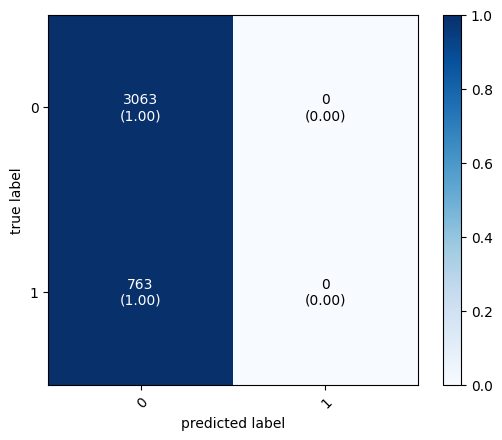

[INFO] model xgb demoró 0.5807721333333333 minutos en ejecutar
nb


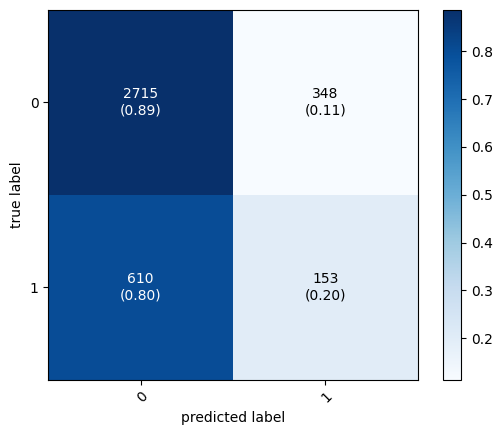

[INFO] model nb demoró 0.0037433833333333335 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


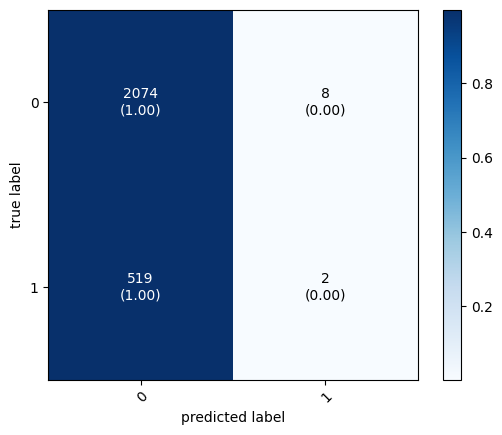

[INFO] model rf demoró 0.9222205833333333 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


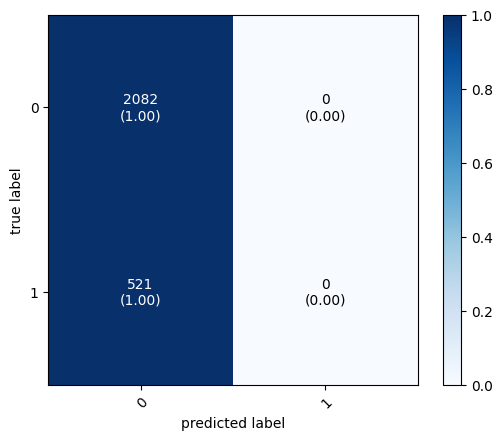

[INFO] model rl demoró 0.20741383333333333 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


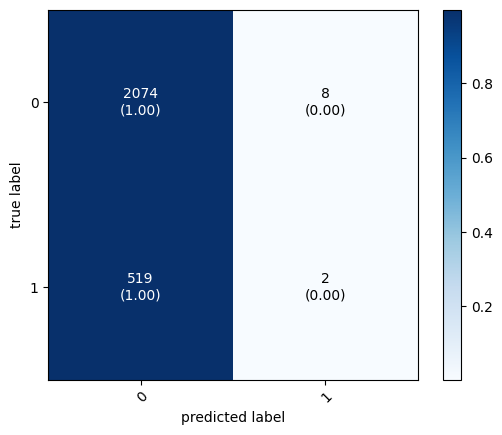

[INFO] model xgb demoró 0.36762738333333334 minutos en ejecutar
nb


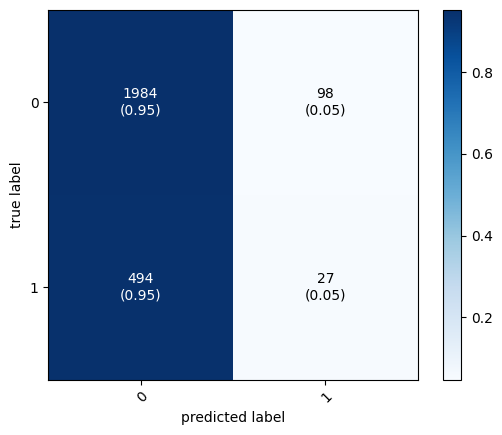

[INFO] model nb demoró 0.0032450666666666663 minutos en ejecutar


In [68]:
momento_dia = ["mañana","tarde","noche"]
models = ["rf","rl","xgb","nb"]
for dia in momento_dia:
    df_filter = df[df["periodo_dia"]==dia]
    if dia == "mañana":
        dia = "manana"
    X = df_filter[features]
    y = df_filter[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666,stratify=y)
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train = ohe.transform(X_train).toarray()
    X_test = ohe.transform(X_test).toarray()

    for model in models:
        start_iter = datetime.now()
        print(model)
        if model == "rf":
            grid_under = GridSearchCV(RandomForestClassifier(), param_rf, refit=True, verbose=1,scoring="f1_weighted")
        elif model == "rl":
            grid_under = GridSearchCV(LogisticRegression(), param_log, refit=True, verbose=1,scoring="f1_weighted")
        elif model == "nb":
            grid_under = GaussianNB()
        elif model == "xgb":
            grid_under = GridSearchCV(XGBClassifier(), param_xgb, refit=True, verbose=1,scoring="f1_weighted")
        path_model_save = f"models/atraso_{dia}/{model}.pickle"
        grid_under.fit(X_train, y_train)
        y_pred = grid_under.predict(X_test)
        metrics_res = get_report(y_test, y_pred)
        metrics_res["modelo"] = model
        metrics_res["tipo_modelo"] = f"atraso_{dia}"
        if metrics is None:
            metrics_res.to_parquet(path_metrics)
            metrics = pd.read_parquet(path_metrics)
        else:
            metrics = pd.read_parquet(path_metrics)
            metrics_res = pd.concat([metrics,metrics_res])
            metrics_res.to_parquet(path_metrics)
        with open(path_model_save,"wb") as f:
            pickle.dump(grid_under,f)
        end_iter = datetime.now()
        print(f"[INFO] model {model} demoró {(end_iter-start_iter).total_seconds()/60} minutos en ejecutar")

rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


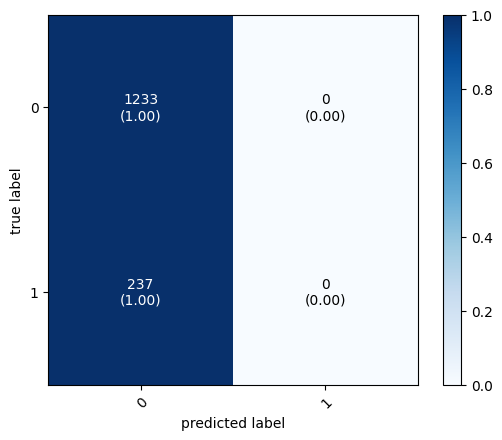

[INFO] model rf demoró 0.6001443666666667 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


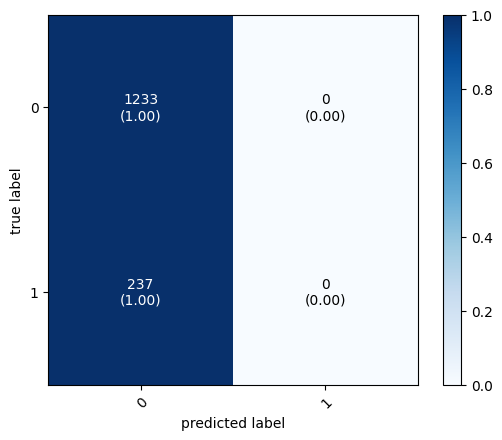

[INFO] model rl demoró 0.0783577 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


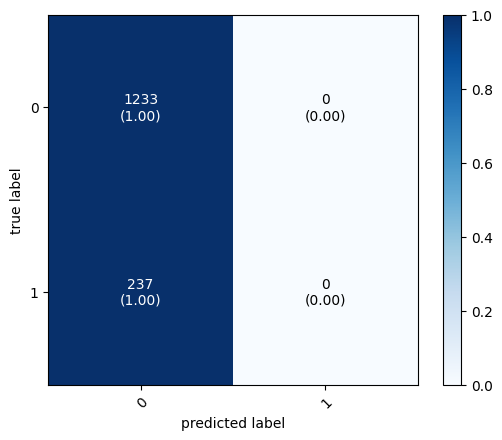

[INFO] model xgb demoró 0.1601309 minutos en ejecutar
nb


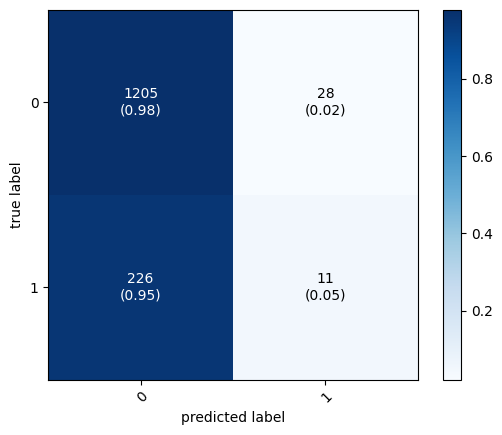

[INFO] model nb demoró 0.0031489499999999998 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


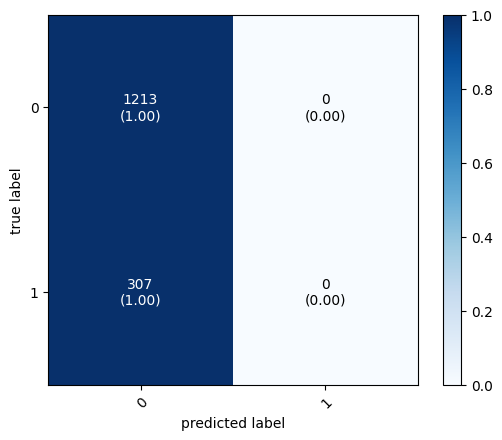

[INFO] model rf demoró 0.6478776333333334 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


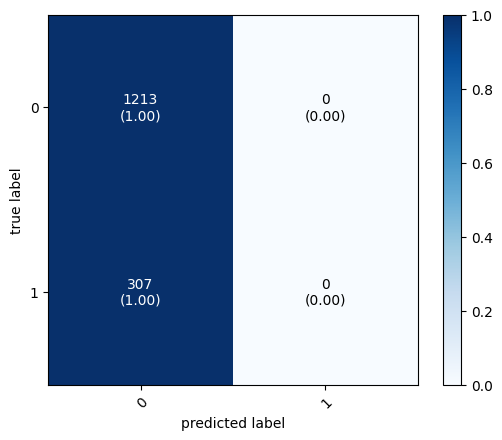

[INFO] model rl demoró 0.09906146666666667 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


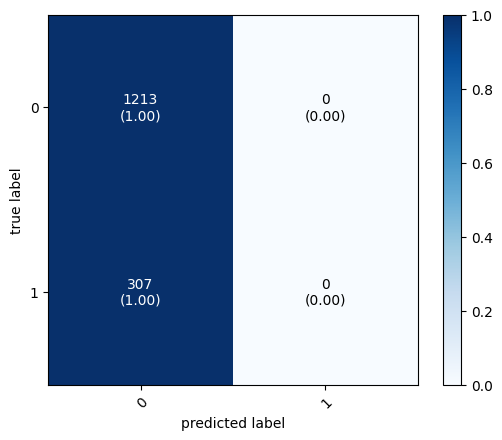

[INFO] model xgb demoró 0.14310723333333333 minutos en ejecutar
nb


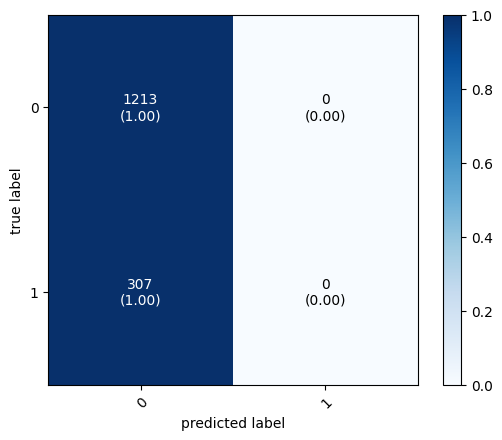

[INFO] model nb demoró 0.0035784000000000002 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


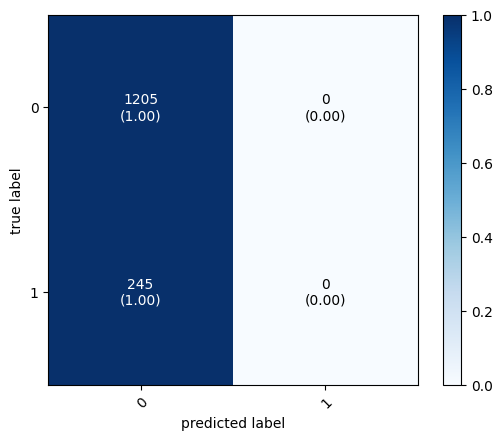

[INFO] model rf demoró 0.6102734166666667 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


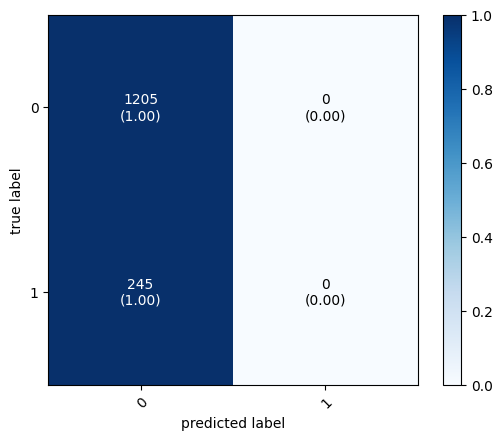

[INFO] model rl demoró 0.0824955 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


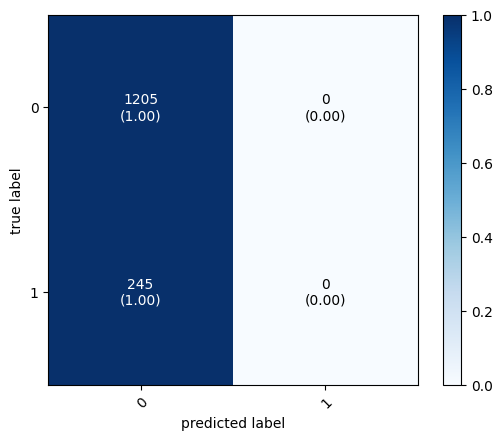

[INFO] model xgb demoró 0.16160185 minutos en ejecutar
nb


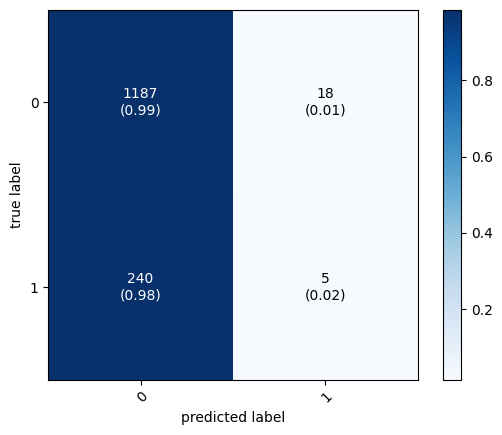

[INFO] model nb demoró 0.00327795 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


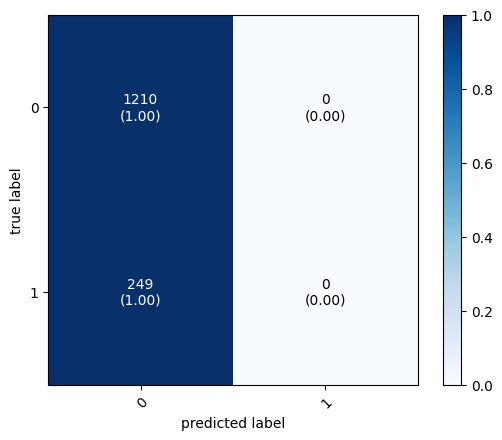

[INFO] model rf demoró 0.6102823833333333 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


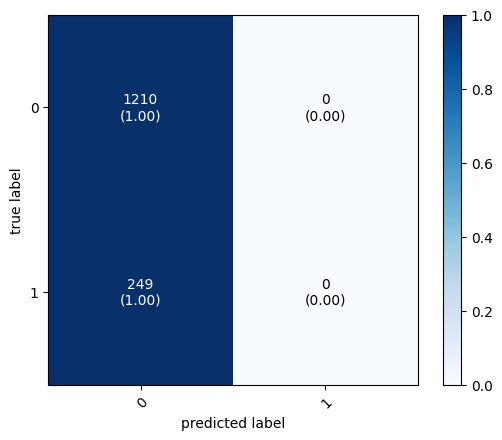

[INFO] model rl demoró 0.07775316666666666 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


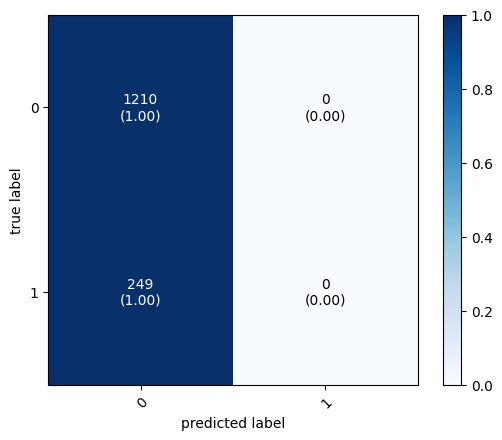

[INFO] model xgb demoró 0.14590588333333335 minutos en ejecutar
nb


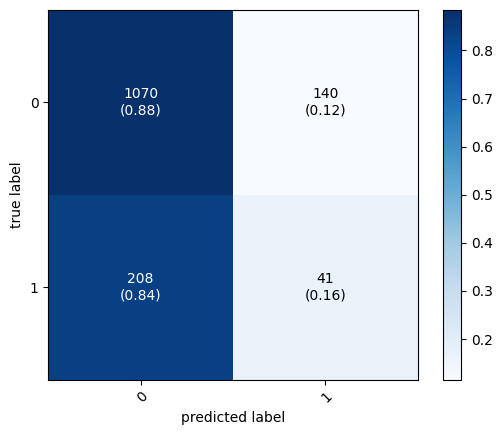

[INFO] model nb demoró 0.004818383333333333 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


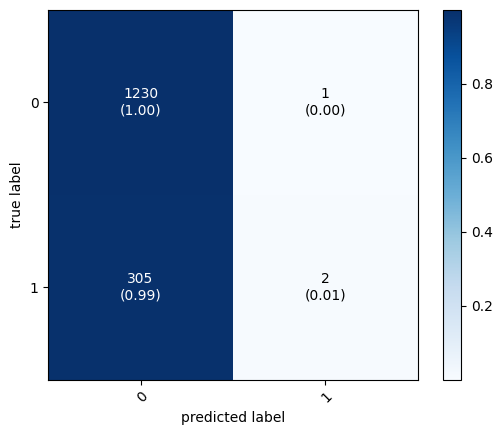

[INFO] model rf demoró 0.61262805 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


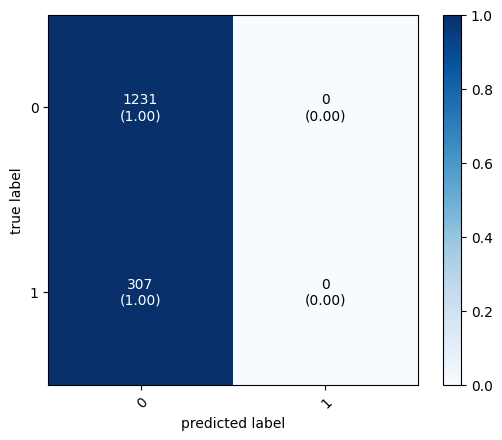

[INFO] model rl demoró 0.08246828333333332 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


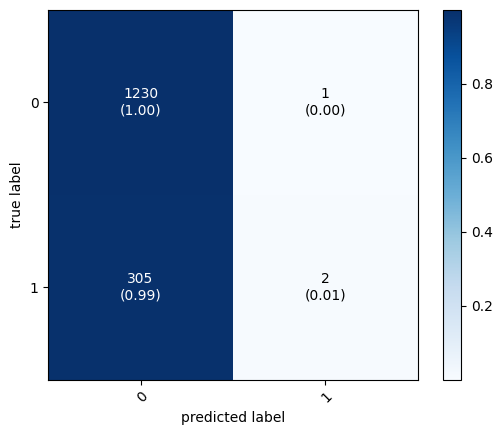

[INFO] model xgb demoró 0.16295571666666667 minutos en ejecutar
nb


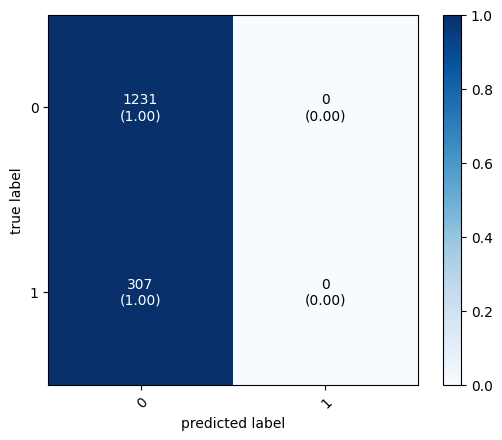

[INFO] model nb demoró 0.0032495000000000002 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


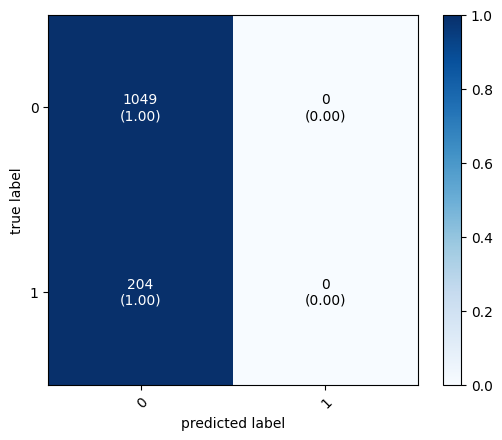

[INFO] model rf demoró 0.5528915333333334 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


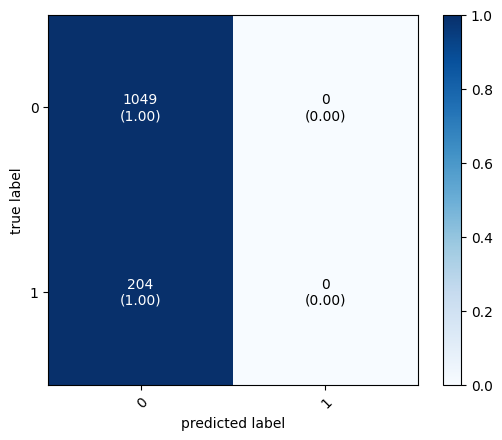

[INFO] model rl demoró 0.05562905 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


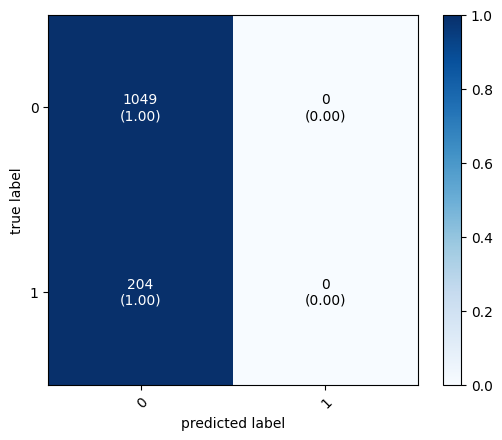

[INFO] model xgb demoró 0.10648468333333333 minutos en ejecutar
nb


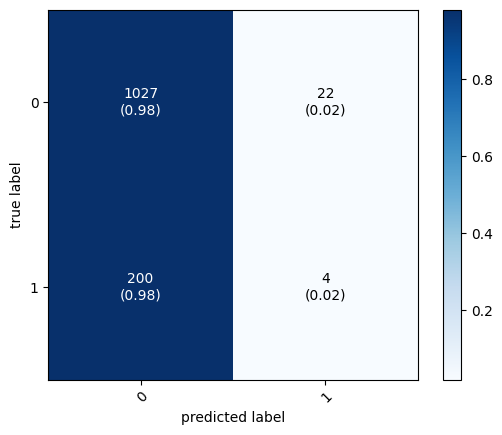

[INFO] model nb demoró 0.003543483333333333 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


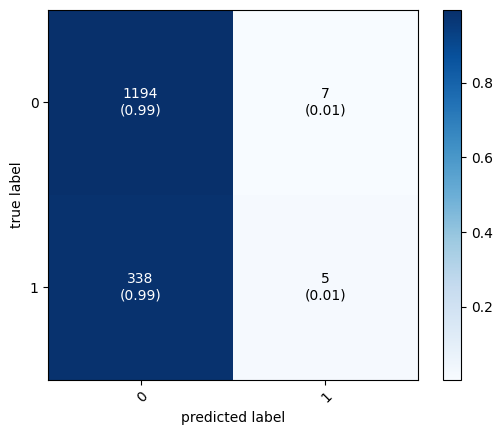

[INFO] model rf demoró 0.5928678000000001 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


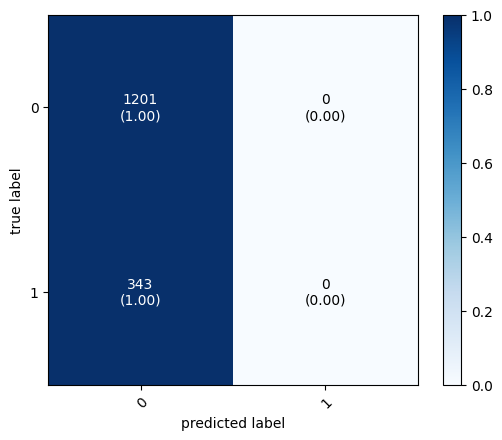

[INFO] model rl demoró 0.0772162 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


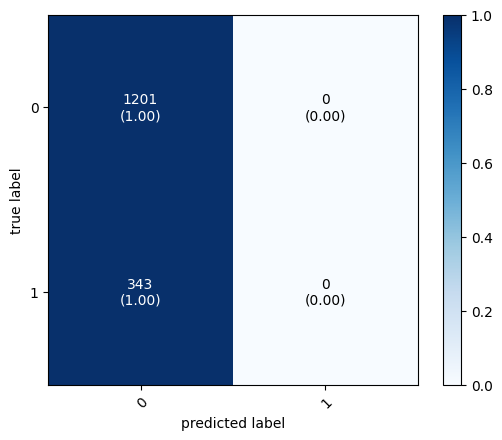

[INFO] model xgb demoró 0.12081983333333332 minutos en ejecutar
nb


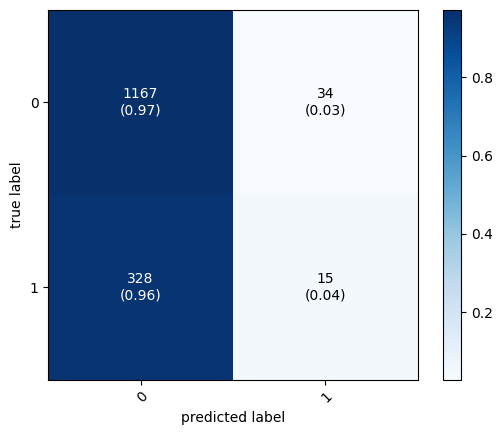

[INFO] model nb demoró 0.0027032333333333334 minutos en ejecutar


In [69]:
dia_semana = df["DIANOM"].drop_duplicates().tolist()
for dia in dia_semana:
    df_filter = df[df["DIANOM"]==dia]
    dia = dia.lower()
    X = df_filter[features]
    y = df_filter[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666,stratify=y)
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train = ohe.transform(X_train).toarray()
    X_test = ohe.transform(X_test).toarray()

    models = ["rf","rl","xgb","nb"]
    for model in models:
        start_iter = datetime.now()
        print(model)
        if model == "rf":
            grid_under = GridSearchCV(RandomForestClassifier(), param_rf, refit = True, verbose = 1,scoring="f1_weighted")
        elif model == "rl":
            grid_under = GridSearchCV(LogisticRegression(), param_log, refit = True, verbose = 1,scoring="f1_weighted")
        elif model == "nb":
            grid_under = GaussianNB()
        elif model == "xgb":
            grid_under = GridSearchCV(XGBClassifier(), param_xgb, refit = True, verbose = 1,scoring="f1_weighted")
        path_model_save = f"models/atraso_{dia}/{model}.pickle"
        grid_under.fit(X_train, y_train)
        y_pred = grid_under.predict(X_test)
        metrics_res = get_report(y_test, y_pred)
        metrics_res["modelo"] = model
        metrics_res["tipo_modelo"] = f"atraso_{dia}"
        if metrics is None:
            metrics_res.to_parquet(path_metrics)
            metrics = pd.read_parquet(path_metrics)
        else:
            metrics = pd.read_parquet(path_metrics)
            metrics_res = pd.concat([metrics,metrics_res])
            metrics_res.to_parquet(path_metrics)
        with open(path_model_save,"wb") as f:
            pickle.dump(grid_under,f)
        end_iter = datetime.now()
        print(f"[INFO] model {model} demoró {(end_iter-start_iter).total_seconds()/60} minutos en ejecutar")

In [87]:
metrics_models = pd.read_parquet(path_metrics)
metrics_models = metrics_models.reset_index()

In [88]:
metrics_models.head()

,index,precision,recall,f1-score,support,modelo,tipo_modelo
0,0,0.815359,0.998201,0.897563,8339.00000,rf,atraso_completo
1,1,0.318182,0.003700,0.007315,1892.00000,rf,atraso_completo
2,accuracy,0.814290,0.814290,0.814290,0.81429,rf,atraso_completo
3,macro avg,0.566770,0.500951,0.452439,10231.00000,rf,atraso_completo
4,weighted avg,0.723417,0.814290,0.732931,10231.00000,rf,atraso_completo


In [89]:
metrics[metrics["index"]=='1'].sort_values(["tipo_modelo","f1-score"],ascending=[False,False])\
                .drop_duplicates(["tipo_modelo"]).sort_values("f1-score",ascending=False)

,index,precision,recall,f1-score,support,modelo,tipo_modelo
56,1,0.305389,0.200524,0.242089,763.0,nb,atraso_tarde
156,1,0.226519,0.164659,0.190698,249.0,nb,atraso_miercoles
36,1,0.212698,0.110016,0.145022,609.0,nb,atraso_manana
16,1,0.226013,0.056025,0.089792,1892.0,nb,atraso_completo
76,1,0.216000,0.051823,0.083591,521.0,nb,atraso_noche
96,1,0.282051,0.046414,0.079710,237.0,nb,atraso_domingo
216,1,0.306122,0.043732,0.076531,343.0,nb,atraso_viernes
136,1,0.217391,0.020408,0.037313,245.0,nb,atraso_martes
196,1,0.153846,0.019608,0.034783,204.0,nb,atraso_sabado
161,1,0.666667,0.006515,0.012903,307.0,rf,atraso_jueves


# Conclusiones

Se probaron diferentes tipos de modelos en diferentes escenarios, se encontró lo siguiente:
- Las variables que se disponen no logran predecir el atraso de un vuelo. Un supuesto que se maneja es que puede ser debido a que la gran mayoría son variables del tipo categóricas.
- Los mejores modelos que se lograron capturar fueron por momento del día, en particular, durante la tarde (entre las 12:00 y las 18:59 hrs).
- De los diferentes modelos con su respectivo tuning de hiperparámetros el que mejor rendimiento tuvo fueron las Redes Bayesianas.

Los modelos utilizados fueron:
- Redes Bayesianas, debido a su simplicidad de construcción y no requiere supuestos de entrada.
- Random Forest, debido a que es un modelo no-paramétrico con baja cantidad de supuestos y suavizamiento de la salida debido a que se construyen n-árboles para que retorne la predicción.
- Xgboost, debido a que es un modelo sequencial que va aprendiendo de los errores del árbol anterior lo cual va construyendo un mejor modelo en cada iteración.+
- Regresión Logística, debido a que es un modelo probabilístico, no requiere normalidad (lo entregué bajo el supuesto que cómo la entrada que se dispone son variables categóricas es altamente probable que no performe muy bien debido a su distribución).

Recomendaría la viabilidad de considerar los modelos por momento del día (mañana, tarde o noche) debido a que fueron los modelos que mejor rendimiento lograron. Las métricas a considerar en este modelo fueron la precision, recall y f1-score debido a que existía un gran desbalance de clases y el objetivo del modelo era capturar si el modelo lograba o no predecir si un vuelo va a salir con atraso.

Las métricas no lograron un buen desempeño, logrando una precision y un recall de 30.1% y un 20.1% respectivamente. Además, la métrica F1-score que es la media armonica de precision y recall obtuvo un valor de 24%. Todas estás métricas corresponden a los vuelos de la tarde (entre las 12:00 y las 18:59 hrs).

# Pasos futuros
- Consideraría agregar variables del clima como por ejemplo, la temperatura en ºC, si ha nevado en la cordillera (caso para aquellos vuelos que deben cruzar la cordillera)
- Tiempo de despeje de la vía (vuelo anterior).
- Embarque, entre otras variables que puedan conllevar a retrasar un vuelo.